<a href="https://colab.research.google.com/github/dinesh110598/Spin_glass_NN/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying ensembles of spin glasses

New notebook to test cuda code

In [ ]:
import numpy as np
import math
from numba import cuda,float32,int32
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk

### Kernels and Simulator class

In [ ]:
@cuda.jit
def ising_couplings (J_nn):
    x,y = cuda.grid(2)
    J_nn [x,y,0] = float32 (1)
    J_nn [x,y,1] = float32 (1)

@cuda.jit
def gaussian_couplings (seed, J_nn):
    x, y = cuda.grid (2)
    #scale = float32(1.73205)
    while True:
        seed[x, y, 0] = np.int32((seed[x, y, 0]*1664525 + 1013904223) % 2**31)
        seed[x, y, 1] = np.int32((seed[x, y, 1]*1664525 + 1013904223) % 2**31)
        u = float32(seed[x, y, 0]/2**30 - 1)
        v = float32(seed[x, y, 1]/2**30 - 1)
        s = u**2 + v**2
        if s>0 and s<1:
            break

    arg = math.sqrt (-2*math.log(s)/s)
    J_nn [x,y,0] = -u*arg
    J_nn [x,y,1] = -v*arg

@cuda.jit
def bimodal_couplings (seed, J_nn):
    x, y = cuda.grid (2)
    seed[x, y, 0] = np.int32((seed[x, y, 0]*1664525 + 1013904223) % 2**31)
    seed[x, y, 1] = np.int32((seed[x, y, 1]*1664525 + 1013904223) % 2**31)
    
    J_nn[x,y,0] = -1. if (seed[x,y,0]/2**31)<0.5 else 1.
    J_nn[x,y,1] = -1. if (seed[x,y,1]/2**31)<0.5 else 1.

@cuda.jit
def update_black (spin, seed, B, Jnn):
    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc(x):
        if x == spin.shape[0]:
            return 0
        else:
            return x

    def sum_nn(x, y, z):
        sum = 0
        sum += Jnn[x,y,0]*spin[bvc(x+1),y,z]
        sum += Jnn[x,y,1]*spin[x,bvc(y+1),z]
        sum += Jnn[x-1,y,0]*spin[x-1,y,z]
        sum += Jnn[x,y-1,1]*spin[x,y-1,z]
        return sum
    
    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        delta = 2*spin[x,y,z]*sum_nn(x,y,z)
        if probs < math.exp(-delta*B[z]):
            spin[x, y, z] *= np.int8(-1)
            #energy[z] += delta

    x, y, z = cuda.grid(3)
    p, q = x%2, y%2
    if x<spin.shape[0] and y<spin.shape[1] and z<spin.shape[2]:
        if (p==0 and q==0) or (p==1 and q==1):
            calc (x, y, z)

@cuda.jit
def update_white(spin, seed, B, Jnn):
    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc(x):
        if x == spin.shape[0]:
            return 0
        else:
            return x

    def sum_nn(x, y, z):
        sum = 0
        sum += Jnn[x,y,0]*spin[bvc(x+1),y,z]
        sum += Jnn[x,y,1]*spin[x,bvc(y+1),z]
        sum += Jnn[x-1,y,0]*spin[x-1,y,z]
        sum += Jnn[x,y-1,1]*spin[x,y-1,z]
        return sum

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        delta = 2*spin[x,y,z]*sum_nn(x,y,z)
        if probs < math.exp(-delta*B[z]):
            spin[x, y, z] *= np.int8(-1)
            #energy[z] += delta

    x, y, z = cuda.grid(3)
    p, q = x % 2, y % 2
    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 1 and q == 0) or (p == 0 and q == 1):
            calc(x, y, z)

@cuda.jit
def parallel_temper (spin, B, J_nn, seed, energy):
    z = cuda.grid(1)
    tid = cuda.threadIdx.x
    m_ = spin.shape [2]
    rand_n = seed[0, 0, tid] % (m_-1) #Returns a number in [0,m_-2]

    #We don't want two threads doing the swapping!
    val0 = B[rand_n]
    val1 = B[rand_n+1]
    e0 = energy[rand_n]
    e1 = energy[rand_n+1]
    rand_unif = np.float32 (seed[0,1,tid] / 2**31)
    arg = (e0 - e1)*(val0 - val1)
    if (arg < 0):
        if rand_unif < math.exp (arg):
            B[rand_n] = val1
            B[rand_n+1] = val0
    else:
        B[rand_n] = val1
        B[rand_n+1] = val0

@cuda.jit
def parallel_temper2(spin, B, J_nn, seed, energy):
    z = cuda.grid(1)

    rand_n = 0 if float32(seed[0, 0, 0]/2**31) < 0.5 else 1
    ptr = 2*z + rand_n
    if ptr < spin.shape[2]-1:
        val0 = B[ptr]
        val1 = B[ptr+1]
        e0 = energy[ptr]
        e1 = energy[ptr+1]
        rand_unif = float32(seed[0, 1, z] / 2**31)
        arg = (e0 - e1)*(val0 - val1)
        if (arg < 0):
            if rand_unif < math.exp(arg):
                B[ptr] = val1
                B[ptr+1] = val0
        else:
            B[ptr] = val1
            B[ptr+1] = val0

@cuda.jit
def calc_energy (spin, J_nn, energy): #m_ threads on a single block...
    def bvc(x):
        if x == spin.shape[0]:
            return 0
        else:
            return x

    z = cuda.grid (1)
    len_ = spin.shape[0]
    ener = 0
    for x in range(len_):
        for y in range(len_):
            ener -= J_nn[x,y,0] * spin[x,y,z]*spin[bvc(x+1),y,z]
            ener -= J_nn[x,y,1] * spin[x,y,z]*spin[x,bvc(y+1),z]

    energy[z] = ener

In [ ]:
class GPUsimulator():
    def __init__(self,lat_len, ens_size):
        self.shape = (lat_len, lat_len)
        self.m = ens_size
        self.tpb = (8, 8, 1)
        self.bpg = (math.ceil(lat_len/self.tpb[0]), math.ceil(lat_len/self.tpb[1]), self.m)
        spin = (2*np.random.randint (0,2,self.shape+(self.m,))-1).astype(np.int8)
        #spin = np.ones (self.shape+(self.m,), np.int8)
        self.vr_spin = cuda.to_device (spin)
        seed = np.random.randint(0, 2**30, size=self.shape+(self.m,), dtype=np.int32)
        self.vr_seed = cuda.to_device(seed)
        self.Jnn_vr = cuda.device_array (self.shape+(2,), dtype=np.float32)
        self.vr_energy = cuda.device_array (self.m, dtype=np.float32)

    def equilib_cold(self,temp): #Test the parallel_tamper kernel
        """Yields a thermalised ensemble of EA systems with parallel tempering"""
        bimodal_couplings[self.bpg[:2], self.tpb[:2]] (self.vr_seed, self.Jnn_vr)
        B = np.linspace (0.6, 2.0, self.m)
        vr_beta = cuda.to_device (B)
        for _ in range (10000):
            for _ in range (2):
                update_black[self.bpg, self.tpb](self.vr_spin, self.vr_seed, 
                                                vr_beta, self.Jnn_vr)
                update_white[self.bpg, self.tpb](self.vr_spin, self.vr_seed, 
                                                vr_beta, self.Jnn_vr)
            calc_energy[1, self.m](self.vr_spin, self.Jnn_vr, self.vr_energy)            
            #parallel_temper[(1,), (8,)] (self.vr_spin,vr_beta,self.Jnn_vr,
                                          #self.vr_seed, self.vr_energy)
            parallel_temper2[1, self.m//2](self.vr_spin,vr_beta,self.Jnn_vr,
                                          self.vr_seed, self.vr_energy)

        calc_energy[(1,), (self.m,)](self.vr_spin, self.Jnn_vr, self.vr_energy)
        spin = self.vr_spin.copy_to_host()
        energy = self.vr_energy.copy_to_host()
        order = np.argsort(energy)
        output = spin[...,order]
        avgs = output[0,0,:]
        output =  np.multiply (output, avgs)
        return output [...,:self.m//2]

    def equilib_hot (self, temp):
        """Yields thermalised ensemble of ferromagnetic Ising Model"""
        bimodal_couplings[self.bpg[:2], self.tpb[:2]] (self.vr_seed, self.Jnn_vr)
        B = (1./temp) * np.ones (self.m, np.float32)
        vr_beta = cuda.to_device(B)
        calc_energy[(1,), (self.m,)](self.vr_spin, self.Jnn_vr, self.vr_energy)
        for _ in range (5000):
            update_black[self.bpg, self.tpb](self.vr_spin, self.vr_seed, 
                                             vr_beta, self.Jnn_vr)
            update_white[self.bpg, self.tpb](self.vr_spin, self.vr_seed,
                                             vr_beta, self.Jnn_vr)
        spin = self.vr_spin.copy_to_host()
        calc_energy[(1,), (self.m,)](self.vr_spin, self.Jnn_vr, self.vr_energy)
        energy = self.vr_energy.copy_to_host()
        avgs = spin[0,0,:]
        output =  np.multiply (spin, (2*(avgs > 0).astype(np.int8) - 1))
        return output

    def generate_train_data(self, train_len, T_c=1.3):
        """Outputs numpy array containing train data with labels"""
        assert (train_len%2 == 0), "train_len must be even"
        t_lattice = []
        t_label = []
        for _ in range(train_len):
            dice = np.random.randint(0, 1+1)
            if dice == 1:
                t_lattice.append(self.equilib_hot(0.5).astype(np.float32))
                t_label.append(np.int32(1))
            else:
                t_lattice.append(self.equilib_hot(2.0).astype(np.float32))
                t_label.append(np.int32(0))
        return np.stack(t_lattice), np.stack(t_label)

    def neural_data(self, low, high, step, brain):
        avg_size = 20
        train_len = math.ceil(((high - low) / step))
        # Denotes size of train_lattice
        t_lattice = []
        temp = np.float32(low)
        for _ in range(train_len):
            for _ in range(avg_size):
                t_lattice.append(self.equilib(temp).astype(np.float32))
            temp += np.float32(step)
        t_lattice = np.stack (t_lattice)

        predictions = brain.predict(t_lattice)

        datax = np.empty(train_len, np.float32)
        datay = np.empty(train_len, np.float32)
        dummy = np.empty(avg_size, np.float32)
        temp = np.float32(low)
        for i in range(train_len):
            datax[i] = temp
            for j in range (avg_size):
                dummy[j] = predictions [i*avg_size + j][1]
            datay[i] = np.mean (dummy)
            temp += step
        _, ax = plt.subplots()
        ax.plot(datax, datay, 'r-', linewidth=2)
        ax.grid()
        plt.show()

### Data preparation

In [ ]:
simulator = GPUsimulator (48,40)

In [ ]:
simulator.equilib_cold (0.5)

In [ ]:
simulator.equilib_hot (0.5)

array([-1.3880209, -1.3862847, -1.3862847, -1.3862847, -1.3862847,
       -1.3845487, -1.3828125, -1.3810763, -1.3810763, -1.3810763,
       -1.3810763, -1.3810763, -1.3810763, -1.3810763, -1.3793403,
       -1.3793403, -1.3793403, -1.3793403, -1.3793403, -1.3793403,
       -1.3793403, -1.3793403, -1.3793403, -1.3776041, -1.3776041,
       -1.3776041, -1.3776041, -1.3776041, -1.3776041, -1.3776041,
       -1.3758681, -1.3758681, -1.3758681, -1.3758681, -1.3741319,
       -1.3741319, -1.3741319, -1.3723959, -1.3723959, -1.3706597],
      dtype=float32)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-df0d6af3-5bce-e313-008f-1c3011d883e7)


In [ ]:
#Very long runtime expected...
train_len = 20
train_lattice, train_label = simulator.generate_train_data (train_len)

In [ ]:
train_label

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
      dtype=int32)

In [ ]:
train_path = '/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/Training Data'
np.save (train_path+'/SqEA2k_48_40_lattice.npy',train_lattice)
np.save (train_path+'/SqEA2k_48_40_label.npy',train_label)

In [ ]:
def __serialize (self, feature1, labels):
        def _int64_feature(value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

        def _bytes_feature(value):
            """Returns a bytes_list from a string / byte."""
            if isinstance(value, type(tf.constant(0))):
                value = value.numpy() 
            return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
        """
        Creates a tf.train.Example message ready to be written to a file.
        """
        # Create a dictionary mapping the feature name to the tf.train.Example-compatible
        # data type.
        feature = {
            'lattices': _bytes_feature(tf.io.serialize_tensor(feature1)),
            'labels': _int64_feature(labels),
        }

        # Create a Features message using tf.train.Example.

        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

# Classifying individual lattices with fixed coupling constants

We first draw a set of coupling constants for a lattice of fixed size from a desired distribution. Then, simulate individual lattices using parallel tempering and train in cold and hot temperatures using a CNN to see if there's a sharp change in the effective "phase parameter"... 

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  10128      0 --:--:-- --:--:-- --:--:-- 10128
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 348.0MB 44kB/s 
+ set +ex
Installation succeeded!


In [ ]:
import numpy as np
import math
from numba import cuda, float32, int32
import tensorflow.keras as tfk
import tensorflow as tf
import cupy as cp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/"

Mounted at /content/drive


## EA model

In [ ]:
#J_nn = np.random.uniform (-1.732051, 1.732051, size=(48,48,2)).astype(np.float32)
#np.save (folder_path+'Coupling_constants/Jnn_uniform.npy', J_nn)

#J_nn = np.random.normal (size=(48,48,2)).astype(np.float32)
#np.save (folder_path+'Coupling_constants/Jnn_gaussian.npy', J_nn)

#J_nn = np.ones (shape=48*48*2, dtype=np.float32)
#pos = np.random.choice (48*48*2, size=48*48, replace=False)
#J_nn [pos] = -1
#J_nn = np.reshape (J_nn, (48,48,2))
#np.save (folder_path+'Coupling_constants/Jnn_bimodal.npy', J_nn)

In [ ]:
@cuda.jit
def update_black (spin, T, Jnn, seed):
    def random_uniform(n, x, y):
        seed[n, x, y] = np.int32((seed[n, x, y]*1664525 + 1013904223) % 2**31)
        return seed[n, x, y] / (2**31)

    def bvc(x):
        if x == spin.shape[1]:
            x = 0
        return x

    def sum_nn(n, x, y):
        sum = 0
        sum += Jnn[x,y,0]*spin[n,bvc(x+1),y]
        sum += Jnn[x,y,1]*spin[n,x,bvc(y+1)]
        sum += Jnn[x-1,y,0]*spin[n,x-1,y]
        sum += Jnn[x,y-1,1]*spin[n,x,y-1]
        return sum
    
    def calc(n, x, y):
        probs = random_uniform(n, x, y)
        delta = 2*spin[n,x,y]*sum_nn(n,x,y)
        if probs < math.exp(-delta/T[n]):
            spin[n, x, y] *= np.int8(-1)
            #energy[z] += delta

    n, x, y = cuda.grid(3)
    p, q = x%2, y%2
    if n<spin.shape[0] and x<spin.shape[1] and y<spin.shape[2]:
        if (p==0 and q==0) or (p==1 and q==1):
            calc (n, x, y)

@cuda.jit
def update_white (spin, T, Jnn, seed):
    def random_uniform(n, x, y):
        seed[n, x, y] = np.int32((seed[n, x, y]*1664525 + 1013904223) % 2**31)
        return seed[n, x, y] / (2**31)

    def bvc(x):
        if x == spin.shape[1]:
            x = 0
        return x

    def sum_nn(n, x, y):
        sum = 0
        sum += Jnn[x,y,0]*spin[n,bvc(x+1),y]
        sum += Jnn[x,y,1]*spin[n,x,bvc(y+1)]
        sum += Jnn[x-1,y,0]*spin[n,x-1,y]
        sum += Jnn[x,y-1,1]*spin[n,x,y-1]
        return sum
    
    def calc(n, x, y):
        probs = random_uniform(n, x, y)
        delta = 2*spin[n,x,y]*sum_nn(n,x,y)
        if probs < math.exp(-delta/T[n]):
            spin[n, x, y] *= np.int8(-1)
            #energy[z] += delta

    n, x, y = cuda.grid(3)
    p, q = x%2, y%2
    if n<spin.shape[0] and x<spin.shape[1] and y<spin.shape[2]:
        if (p==0 and q==1) or (p==1 and q==0):
            calc (n, x, y)

@cuda.jit
def parallel_temper (spin, B, J_nn, seed, energy):
    z = cuda.grid(1)
    tid = cuda.threadIdx.x
    m_ = spin.shape [2]
    rand_n = seed[0, 0, tid] % (m_-1) #Returns a number in [0,m_-2]

    #We don't want two threads doing the swapping!
    val0 = B[rand_n]
    val1 = B[rand_n+1]
    e0 = energy[rand_n]
    e1 = energy[rand_n+1]
    rand_unif = np.float32 (seed[0,1,tid] / 2**31)
    arg = (e0 - e1)*(val0 - val1)
    if (arg < 0):
        if rand_unif < math.exp (arg):
            B[rand_n] = val1
            B[rand_n+1] = val0
    else:
        B[rand_n] = val1
        B[rand_n+1] = val0

@cuda.jit
def parallel_temper2(spin, T, seed, energy):
    z = cuda.grid(1)

    rand_n = 0 if float32(seed[0, 0, 0]/2**31) < 0.5 else 1
    ptr = 2*z + rand_n
    if ptr < energy.shape[0]-1:
        val0 = 1./T[ptr]
        val1 = 1./T[ptr+1]
        e0 = energy[ptr]
        e1 = energy[ptr+1]
        rand_unif = float32(seed[0, 1, z] / 2**31)
        arg = (e0 - e1)*(val0 - val1)
        if (arg < 0):
            if rand_unif < math.exp(arg):
                T[ptr] = 1/val1
                T[ptr+1] = 1/val0
        else:
            T[ptr] = 1/val1
            T[ptr+1] = 1/val0

@cuda.jit
def calc_energy (spin, J_nn, energy): #m_ threads on a single block...
    def bvc(x):
        if x == spin.shape[1]:
            return 0
        else:
            return x

    n = cuda.grid (1)
    len_ = spin.shape[1]
    ener = 0
    for x in range(len_):
        for y in range(len_):
            ener -= J_nn[x,y,0] * spin[n,x,y]*spin[n,bvc(x+1),y]
            ener -= J_nn[x,y,1] * spin[n,x,y]*spin[n,x,bvc(y+1)]

    energy[n] = ener

In [ ]:
class EASimulator ():
    def __init__ (self,lat_len= 48, dist= 'uniform'):
        "The accepted values of 'dist' argument are: 'uniform', 'bimodal' or 'gaussian'"
        self.J_nn = cp.asarray (np.load (folder_path+"Coupling_constants/Jnn_"+dist+".npy"))
        self.shape = (lat_len, lat_len)
        self.lat_len = lat_len
        self.tpb = (1,8,8)
        self.m = 80
        self.spin = cp.random.choice ([-1,1], (self.m,)+self.shape).astype(np.int8)
        self.seed = cp.random.randint (-10000,10000, (self.m,)+self.shape, np.int32)
        self.energy = cp.zeros (self.m, np.float32)
        
    def equilib_cold (self, temp):
        vr_T = cp.linspace (temp, temp+2.5, self.m, dtype=np.float32)
        bpg = (self.m,self.shape[0]//self.tpb[1],self.shape[1]//self.tpb[2])
        for _ in range(250):
            for _ in range (5):
                update_black[bpg,self.tpb] (self.spin, vr_T, self.J_nn, self.seed)
                update_white[bpg,self.tpb] (self.spin, vr_T, self.J_nn, self.seed)
            calc_energy[1, self.m](self.spin, self.J_nn, self.energy)
            parallel_temper2[1, self.m//2] (self.spin, vr_T, self.seed, self.energy)
        vr_T = cp.full (self.m, temp, np.float32)
        for _ in range (500):
            update_black[bpg, self.tpb] (self.spin, vr_T, self.J_nn, self.seed)
            update_white[bpg, self.tpb] (self.spin, vr_T, self.J_nn, self.seed)
        return cp.asnumpy(self.spin).astype(np.float32)

    def equilib_hot (self, temp):
        vr_T = cp.full (self.m, temp, np.float32)
        bpg = (self.m,self.shape[0]//self.tpb[1],self.shape[1]//self.tpb[2])
        for _ in range (500):
            update_black[bpg, self.tpb] (self.spin, vr_T, self.J_nn, self.seed)
            update_white[bpg, self.tpb] (self.spin, vr_T, self.J_nn, self.seed)
        return cp.asnumpy(self.spin).astype (np.float32)
    
    def generate_train_data (self,train_len=4000):
        t_lattice = []
        t_label = []
        for _ in range(train_len//(2*self.m)):
            t_lattice.append (self.equilib_cold (0.5))
            t_label.append (np.ones (self.m, np.int32))
        for _ in range(train_len//(2*self.m)):
            t_lattice.append (self.equilib_hot (4.5))
            t_label.append (np.zeros (self.m, np.int32))
        t_lattice = 0.5*np.concatenate (t_lattice)
        t_label = np.concatenate (t_label)
        t_data = tf.data.Dataset.from_tensor_slices ((t_lattice, t_label))
        return t_data.shuffle (buffer_size=train_len)

    def neural_data (self, low, high, step, brain):
        _len = math.ceil((high - low) / step)
        t_lattice = []
        datax = []
        temp = low
        for _ in range (_len):
            t_lattice.append (np.stack([self.equilib_cold (temp)], axis=-1))
            datax.append (temp)
            temp += step
        t_lattice = np.concatenate (t_lattice)
        datax = np.asarray (datax)
        predictions = brain.predict (t_lattice)
        datay = np.empty (_len, np.float32)
        for i in range (_len):
            start = i*self.m
            end = (i+1)*self.m
            datay[i] = predictions[start:end,0].mean()
        graph, ax = plt.subplots()
        ax.plot (datax, datay, 'r-', linewidth = 2)
        ax.grid ()
        plt.show ()
        return predictions[:,0]

### Uniform couplings

In [ ]:
simulator = EASimulator(dist='uniform')

In [ ]:
type (simulator.equilib_cold (0.5))

cupy.core.core.ndarray

In [ ]:
train_data = simulator.generate_train_data (8000)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
def serialize_example(lattice, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """

    def _bytes_feature(value):
        """Returns a bytes_list from a string / byte."""
        #value = tf.io.serialize_tensor(value)
        if isinstance(value, type(tf.constant(0))):
            value = tf.io.serialize_tensor(value).numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    # Create a dictionary mapping the feature name to the tf.train.Example-compatible
    # data type.
    feat = { 
        'lattice': _bytes_feature(lattice),
        'label': _int64_feature(label),
    }
    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feat))
    return tf.reshape(example_proto.SerializeToString(),())

def tf_serialize_example(lattice,label):
    tf_string = tf.py_function(
        serialize_example,
        (lattice,label),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar


serialised_dataset = train_data.map (tf_serialize_example)

filename = folder_path+'Training Data/SqEA2d_48.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialised_dataset)

In [ ]:
def resize (lattice, label):
    lattice = tf.stack ([lattice], axis=-1)
    return lattice, label

train_data = train_data.batch (simulator.m).map (resize)
val_data = train_data.skip (6000)
train_data = train_data.take (6000)

In [ ]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = simulator.shape+(1,)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [ ]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_data, epochs=2, validation_data=val_data)

Epoch 1/2
100/100 [==============================] - 2s 19ms/step - loss: 0.0766 - accuracy: 0.9710
Epoch 2/2
100/100 [==============================] - 2s 17ms/step - loss: 1.7641e-04 - accuracy: 1.0000


In [ ]:
brain.save(folder_path+'NN Models/SqEA2d_48_uniform.h5')

In [ ]:
brain = tfk.models.load_model (folder_path+'NN Models/SqEA2d_48_uniform.h5')

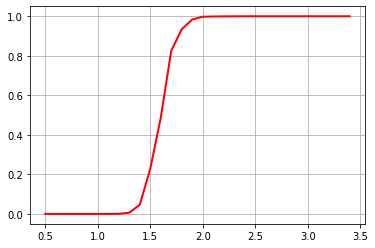

In [ ]:
predictions = simulator.neural_data (0.5, 3.5, 0.1, brain)

In [ ]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

### Gaussian couplings

In [ ]:
simulator = EASimulator (dist='gaussian')

In [ ]:
train_data = simulator.generate_train_data (8000)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
def resize (lattice, label):
    lattice = tf.stack ([lattice], axis=-1)
    return lattice, label

val_data = train_data.skip (6000)
train_data = train_data.take (6000)

In [ ]:
val_data = val_data.map (resize)
train_data = train_data.map (resize)

In [ ]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = simulator.shape+(1,)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [ ]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_data, epochs=2, validation_data=val_data)

Epoch 1/2
100/100 [==============================] - 1s 10ms/step - loss: 0.0832 - accuracy: 0.9672
Epoch 2/2
100/100 [==============================] - 1s 9ms/step - loss: 0.0010 - accuracy: 1.0000


In [ ]:
brain.save(folder_path+'NN Models/SqEA2d_48_gaussian.h5')

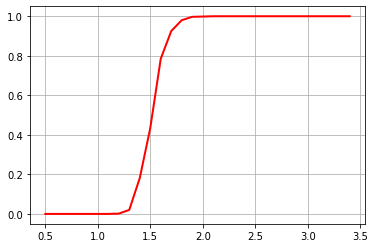

In [ ]:
predictions = simulator.neural_data (0.5, 3.5, 0.1, brain)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

### Bimodal couplings

In [ ]:
simulator = EASimulator (dist='bimodal')

In [ ]:
spin = simulator.equilib_cold (0.5)
val = np.empty (100, np.float32)
for i in range (100):
    pos = np.random.choice (simulator.m, 2, replace=False)
    val[i] = np.abs(np.mean(spin[pos[0]]*spin[pos[1]]))

In [ ]:
val.mean()

0.08648439

In [ ]:
train_data = simulator.generate_train_data (8000)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
def resize (lattice, label):
    lattice = tf.stack ([lattice], axis=-1)
    return lattice, label

val_data = train_data.skip (6000)
train_data = train_data.take (6000)

In [ ]:
val_data = val_data.map (resize)
train_data = train_data.map (resize)

In [ ]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = simulator.shape+(1,)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [ ]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_data, epochs=2, validation_data=val_data)

Epoch 1/2
100/100 [==============================] - 1s 10ms/step - loss: 0.0504 - accuracy: 0.9764
Epoch 2/2
100/100 [==============================] - 1s 9ms/step - loss: 9.0548e-05 - accuracy: 1.0000


In [ ]:
brain.save(folder_path+'NN Models/SqEA2d_48_bimodal.h5')

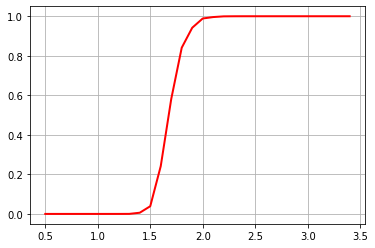

In [ ]:
predictions = simulator.neural_data (0.5, 3.5, 0.1, brain)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# Classify Square Uniform EA and Triangular AFM lattices

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   2449      0 --:--:-- --:--:-- --:--:--  2445
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 348.0MB 24kB/s 
+ set +ex
Installation succeeded!


In [ ]:
import math
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow as tf
from numba import cuda, float32, int32

In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/"

Mounted at /content/drive


### Necessary cuda kernels

In [ ]:
@cuda.jit
def update_red(spin, seed, T):
    J = -1.0  # Nearest neighbour coupling constant

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x       

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*J*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    p, q = x % 3, y % 2

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 0 and q == 0) or (p == 1 and q == 1):
            calc(x, y, z)

@cuda.jit
def update_blue(spin, seed, T):
    J = -1.0  # Nearest neighbour coupling constant

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*J*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    p, q = x % 3, y % 2

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 1 and q == 0) or (p == 2 and q == 1):
            calc(x, y, z)

@cuda.jit
def update_green (spin, seed, T):
    J = -1.0  # Nearest neighbour coupling constant

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*J*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    p, q = x % 3, y % 2

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 2 and q == 0) or (p == 0 and q == 1):
            calc(x, y, z)

@cuda.jit
def calc_energy_Tri (spin, energy):
    def bvc (x):
        if x == spin.shape[1]:
            x = 0
        return x
    
    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value
    
    ener = 0
    z = cuda.grid (1)
    for x in range (spin.shape[0]):
        for y in range (spin.shape[1]):
            ener -= spin[x,y,z]*sum_nn(x,y,z)
    energy[z] = 0.5*ener

In [ ]:
@cuda.jit
def update_black(spin, seed, T, Jnn):
    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc(x):
        if x == spin.shape[0]:
            return 0
        else:
            return x

    def sum_nn(x, y, z):
        sum = 0
        sum += Jnn[x, y, 0]*spin[bvc(x+1), y, z]
        sum += Jnn[x, y, 1]*spin[x, bvc(y+1), z]
        sum += Jnn[x-1, y, 0]*spin[x-1, y, z]
        sum += Jnn[x, y-1, 1]*spin[x, y-1, z]
        return sum

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        delta = 2*spin[x, y, z]*sum_nn(x, y, z)
        if probs < math.exp(-delta/T[0]):
            spin[x, y, z] *= np.int8(-1)
            #energy[z] += delta

    x, y, z = cuda.grid(3)
    p, q = x % 2, y % 2
    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 0 and q == 0) or (p == 1 and q == 1):
            calc(x, y, z)

@cuda.jit
def update_white(spin, seed, T, Jnn):
    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc(x):
        if x == spin.shape[0]:
            return 0
        else:
            return x

    def sum_nn(x, y, z):
        sum = 0
        sum += Jnn[x, y, 0]*spin[bvc(x+1), y, z]
        sum += Jnn[x, y, 1]*spin[x, bvc(y+1), z]
        sum += Jnn[x-1, y, 0]*spin[x-1, y, z]
        sum += Jnn[x, y-1, 1]*spin[x, y-1, z]
        return sum

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        delta = 2*spin[x, y, z]*sum_nn(x, y, z)
        if probs < math.exp(-delta/T[0]):
            spin[x, y, z] *= np.int8(-1)
            #energy[z] += delta

    x, y, z = cuda.grid(3)
    p, q = x % 2, y % 2
    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 1 and q == 0) or (p == 0 and q == 1):
            calc(x, y, z)

@cuda.jit
def parallel_temper(spin, T, seed, energy):
    z = cuda.grid(1)

    rand_n = 0 if float32(seed[0, 0, 0]/2**31) < 0.5 else 1
    ptr = 2*z + rand_n
    if ptr < energy.shape[0]-1:
        val0 = 1./T[ptr]
        val1 = 1./T[ptr+1]
        e0 = energy[ptr]
        e1 = energy[ptr+1]
        rand_unif = float32(seed[0, 1, z] / 2**31)
        arg = (e0 - e1)*(val0 - val1)
        if (arg < 0):
            if rand_unif < math.exp(arg):
                T[ptr] = 1/val1
                T[ptr+1] = 1/val0
        else:
            T[ptr] = 1/val1
            T[ptr+1] = 1/val0

@cuda.jit
def calc_energy (spin, J_nn, energy): #m_ threads on a single block...
    def bvc(x):
        if x == spin.shape[1]:
            return 0
        else:
            return x

    z = cuda.grid (1)
    len_ = spin.shape[1]
    ener = 0
    for x in range(len_):
        for y in range(len_):
            ener -= J_nn[x,y,0] * spin[x,y,z]*spin[bvc(x+1),y,z]
            ener -= J_nn[x,y,1] * spin[x,y,z]*spin[x,bvc(y+1),z]

    energy[z] = ener

### Simulator class

In [ ]:
class SpinGlassData ():
    def __init__(self, lat_len= 48, ens_size=80):
        self.shape = (lat_len, lat_len)
        self.m = ens_size
        self.tpb = (8,8,1)
        self.spin = cp.random.choice ([1,-1], self.shape+(self.m,)).astype(np.int8)
        self.spin2 = cp.random.choice ([1,-1], self.shape+(self.m//2,)).astype(np.int8)
        self.seed = cp.random.randint (-10000,10000, size=self.shape+(self.m,),
                                       dtype=np.int32)
        self.energy = cp.zeros (self.m, np.float32)
        self.energy2 = cp.zeros (self.m//2, np.float32)
    
    def equilib_EA (self):
        temp = 0.5
        J_nn = cp.random.uniform (-1.73205, 1.73205, self.shape+(2,), dtype=np.float32)
        vr_T = cp.linspace (temp, temp+2.5, self.m, dtype=np.float32)
        bpg = (self.shape[0]//self.tpb[0],self.shape[1]//self.tpb[1], self.m)
        for _ in range(250):
            for _ in range (5):
                update_black[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
                update_white[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
            calc_energy[1, self.m](self.spin, J_nn, self.energy)
            parallel_temper[1, self.m//2] (self.spin, vr_T, self.seed, self.energy)
        vr_T = cp.full (self.m, temp, np.float32)
        for _ in range (500):
            update_black[bpg, self.tpb] (self.spin, self.seed, vr_T, J_nn)
            update_white[bpg, self.tpb] (self.spin, self.seed, vr_T, J_nn)
        calc_energy[1, self.m](self.spin, J_nn, self.energy)
        order = cp.asnumpy(cp.argsort (self.energy))
        return cp.asnumpy(self.spin)[...,order[:self.m//2]]

    def equilib_TriAFM (self):
        temp = 0.5
        bpg = (self.shape[0]//self.tpb[0], self.shape[1]//self.tpb[1], self.m)
        vr_T = cp.array ([temp])
        for _ in range (500):
            update_red[bpg, self.tpb] (self.spin2, self.seed, vr_T)
            update_blue[bpg, self.tpb] (self.spin2, self.seed, vr_T)
            update_green[bpg, self.tpb] (self.spin2, self.seed, vr_T)
        calc_energy_Tri[1, self.m//2](self.spin2, self.energy2)
        order = cp.asnumpy(cp.argsort (self.energy2))
        return cp.asnumpy(self.spin2)[...,order]
    
    def generate_train_data (self, train_len=2000):
        t_lattice = []
        t_label = []
        for _ in range (train_len//2):
            t_lattice.append (self.equilib_EA())
            t_label.append (0)
        for _ in range (train_len//2):
            t_lattice.append (self.equilib_TriAFM())
            t_label.append (1)
        t_lattice = (0.5*np.stack (t_lattice)).astype (np.float32)
        t_label = np.stack (t_label).astype (np.int8)
        t_data = tf.data.Dataset.from_tensor_slices ((t_lattice, t_label))
        return t_data.shuffle (buffer_size=train_len)

### Data generation

In [ ]:
simulator = SpinGlassData ()

In [ ]:
train_data = simulator.generate_train_data (500)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

### Saving and Loading Data

In [ ]:
def save_dataset (num, train_data):
    def serialize_example(lattice, label):
        """
        Creates a tf.train.Example message ready to be written to a file.
        """

        def _bytes_feature(value):
            """Returns a bytes_list from a string / byte."""
            #value = tf.io.serialize_tensor(value)
            if isinstance(value, type(tf.constant(0))):
                value = tf.io.serialize_tensor(value).numpy()
            return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

        def _int64_feature(value):
            """Returns an int64_list from a bool / enum / int / uint."""
            return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

        # Create a dictionary mapping the feature name to the tf.train.Example-compatible
        # data type.
        feat = { 
            'lattice': _bytes_feature(lattice),
            'label': _int64_feature(label),
        }
        # Create a Features message using tf.train.Example.
        example_proto = tf.train.Example(features=tf.train.Features(feature=feat))
        return tf.reshape(example_proto.SerializeToString(),())

    def tf_serialize_example(lattice,label):
        tf_string = tf.py_function(
            serialize_example,
            (lattice,label),  # pass these args to the above function.
            tf.string)      # the return type is `tf.string`.
        return tf.reshape(tf_string, ()) # The result is a scalar


    serialised_dataset = train_data.map (tf_serialize_example)

    filename = folder_path+'Training Data/EA_TriAFM2d_48_500('+num+').tfrecord'
    writer = tf.data.experimental.TFRecordWriter(filename)
    writer.write(serialised_dataset)

save_dataset ('4',train_data)

In [ ]:
def extract_dataset (num):
    filename = folder_path+'Training Data/EA_TriAFM2d_48_500('+num+').tfrecord'
    raw_dataset = tf.data.TFRecordDataset(filename)

    def _parse_function(example_proto):
        # Parse the input `tf.train.Example` proto using the dictionary below.
        feature_description = { 
            'lattice': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        return tf.io.parse_single_example(example_proto, feature_description)

    parsed_dataset = raw_dataset.map(_parse_function)

    def lat_parser (record):
        record = (tf.ensure_shape (tf.io.parse_tensor(record['lattice'],tf.float32),
                                   simulator.shape+(simulator.m//2,)),
                  record['label'])
        return record
    dataset = parsed_dataset.map (lat_parser)
    return dataset

train_data = extract_dataset ('1')
train_data = train_data.concatenate(extract_dataset ('2'))
train_data = train_data.concatenate(extract_dataset ('3'))
train_data = train_data.concatenate(extract_dataset ('4'))

In [ ]:
val_data = train_data.take (400)
train_data = train_data.skip (400)
train_data = train_data.batch (8)
val_data = val_data.batch (8)

## Neural network initialization and training

In [ ]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = simulator.shape+(simulator.m//2,)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [ ]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_data, epochs=1, validation_data=val_data)

200/200 [==============================] - 3s 14ms/step - loss: 0.5319 - accuracy: 0.7375 - val_loss: 0.0849 - val_accuracy: 1.0000


In [ ]:
brain.save(folder_path+'NN Models/EA_TriAFM2d_48.h5')

Testing neural network accuracy

In [ ]:
test_data = simulator.generate_train_data (200)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
test_data = test_data.batch (8)
brain.evaluate (test_data)

25/25 [==============================] - 0s 4ms/step - loss: 0.0914 - accuracy: 1.0000


[0.09139034152030945, 1.0]

# Classify Triangular Uniform EA and Triangular AFM lattices

In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  12343      0 --:--:-- --:--:-- --:--:-- 12440
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 369.6MB 47kB/s 
+ set +ex
Installation succeeded!


In [ ]:
import math
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow as tf
from numba import cuda, float32, int32

In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/"

Mounted at /content/drive


## Necessary cuda kernels

While visualizing, I imagine x as vertical and y as horizontal axes...

In [ ]:
#Triangular AFM Simulation
@cuda.jit
def update_red(spin, seed, T):
    J = -1.0  # Nearest neighbour coupling constant

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x       

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*J*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    q, p = x % 2, y % 3

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 0 and q == 0) or (p == 1 and q == 1):
            calc(x, y, z)

@cuda.jit
def update_blue(spin, seed, T):
    J = -1.0  # Nearest neighbour coupling constant

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*J*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    q, p = x % 2, y % 3

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 1 and q == 0) or (p == 2 and q == 1):
            calc(x, y, z)

@cuda.jit
def update_green (spin, seed, T):
    J = -1.0  # Nearest neighbour coupling constant

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*J*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    q, p = x % 2, y % 3

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 2 and q == 0) or (p == 0 and q == 1):
            calc(x, y, z)

@cuda.jit
def calc_energy_Tri (spin, energy):
    def bvc (x):
        if x == spin.shape[1]:
            x = 0
        return x
    
    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices

        value = 0
        value += spin[bvc(x+1), y, z]
        if (x % 2 == 0):
            value += spin[bvc(x+1), y-1, z]
        else:
            value += spin[bvc(x+1), bvc(y+1), z]

        value += spin[x-1, y, z]
        if (x % 2 == 0):
            value += spin[x-1, y-1, z]
        else:
            value += spin[x-1, bvc(y+1), z]

        value += spin[x, bvc(y+1), z]
        value += spin[x, y-1, z]

        return value
    
    ener = 0
    z = cuda.grid (1)
    for x in range (spin.shape[0]):
        for y in range (spin.shape[1]):
            ener -= spin[x,y,z]*sum_nn(x,y,z)
    energy[z] = 0.5*ener

In [ ]:
#Triangular EA Simulation
@cuda.jit
def update_red_ea(spin, seed, T, J_nn):

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x       

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices
        value = 0.
        if (x % 2 == 0):
            value += J_nn[x,y,0]*spin[bvc(x+1), y, z]
            value += J_nn[bvc(x+1),y-1,2]*spin[bvc(x+1), y-1, z]
            value += J_nn[x,y,2]*spin[x-1, y, z]
            value += J_nn[x-1,y-1,0]*spin[x-1, y-1, z]
        else:
            value += J_nn[x,y,0]*spin[bvc(x+1), bvc(y+1), z]
            value += J_nn[bvc(x+1),y,2]*spin[bvc(x+1), y, z]
            value += J_nn[x,y,2]*spin[x-1, bvc(y+1), z]
            value += J_nn[x-1,y,0]*spin[x-1, y, z]

        value += J_nn[x,y,1]*spin[x, bvc(y+1), z]
        value += J_nn[x,y-1,1]*spin[x, y-1, z]
        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    q, p = x % 2, y % 3

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 0 and q == 0) or (p == 1 and q == 1):
            calc(x, y, z)

@cuda.jit
def update_blue_ea(spin, seed, T, J_nn):

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x       

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices
        value = 0.
        if (x % 2 == 0):
            value += J_nn[x,y,0]*spin[bvc(x+1), y, z]
            value += J_nn[bvc(x+1),y-1,2]*spin[bvc(x+1), y-1, z]
            value += J_nn[x,y,2]*spin[x-1, y, z]
            value += J_nn[x-1,y-1,0]*spin[x-1, y-1, z]
        else:
            value += J_nn[x,y,0]*spin[bvc(x+1), bvc(y+1), z]
            value += J_nn[bvc(x+1),y,2]*spin[bvc(x+1), y, z]
            value += J_nn[x,y,2]*spin[x-1, bvc(y+1), z]
            value += J_nn[x-1,y,0]*spin[x-1, y, z]

        value += J_nn[x,y,1]*spin[x, bvc(y+1), z]
        value += J_nn[x,y-1,1]*spin[x, y-1, z]
        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    q, p = x % 2, y % 3

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 1 and q == 0) or (p == 2 and q == 1):
            calc(x, y, z)

#Triangular EA Simulation
@cuda.jit
def update_green_ea(spin, seed, T, J_nn):

    def random_uniform(x, y, z):
        seed[x, y, z] = np.int32((seed[x, y, z]*1664525 + 1013904223) % 2**31)
        return seed[x, y, z] / (2**31)

    def bvc (x):
        if x == spin.shape[0]:
            x = 0
        return x       

    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices
        value = 0.
        if (x % 2 == 0):
            value += J_nn[x,y,0]*spin[bvc(x+1), y, z]
            value += J_nn[bvc(x+1),y-1,2]*spin[bvc(x+1), y-1, z]
            value += J_nn[x,y,2]*spin[x-1, y, z]
            value += J_nn[x-1,y-1,0]*spin[x-1, y-1, z]
        else:
            value += J_nn[x,y,0]*spin[bvc(x+1), bvc(y+1), z]
            value += J_nn[bvc(x+1),y,2]*spin[bvc(x+1), y, z]
            value += J_nn[x,y,2]*spin[x-1, bvc(y+1), z]
            value += J_nn[x-1,y,0]*spin[x-1, y, z]

        value += J_nn[x,y,1]*spin[x, bvc(y+1), z]
        value += J_nn[x,y-1,1]*spin[x, y-1, z]
        return value

    def calc(x, y, z):
        probs = random_uniform(x, y, z)
        if (probs < math.exp(-2*spin[x, y, z]*sum_nn(x, y, z)/T[0])):
            spin[x, y, z] *= np.int8(-1)

    x, y, z = cuda.grid(3)
    q, p = x % 2, y % 3

    if x < spin.shape[0] and y < spin.shape[1] and z < spin.shape[2]:
        if (p == 2 and q == 0) or (p == 0 and q == 1):
            calc(x, y, z)

@cuda.jit
def parallel_temper(spin, T, seed, energy):
    z = cuda.grid(1)

    rand_n = 0 if float32(seed[0, 0, 0]/2**31) < 0.5 else 1
    ptr = 2*z + rand_n
    if ptr < energy.shape[0]-1:
        val0 = 1./T[ptr]
        val1 = 1./T[ptr+1]
        e0 = energy[ptr]
        e1 = energy[ptr+1]
        rand_unif = float32(seed[0, 1, z] / 2**31)
        arg = (e0 - e1)*(val0 - val1)
        if (arg < 0):
            if rand_unif < math.exp(arg):
                T[ptr] = 1/val1
                T[ptr+1] = 1/val0
        else:
            T[ptr] = 1/val1
            T[ptr+1] = 1/val0

@cuda.jit
def calc_energy_Triea (spin, energy, J_nn):
    def bvc (x):
        if x == spin.shape[1]:
            x = 0
        return x
    
    def sum_nn(x, y, z):  # This adds spins of six neighbours instead of 4 subject to
        #many constraints characteristic of triangular lattices
        value = 0.
        if (x % 2 == 0):
            value += J_nn[x,y,0]*spin[bvc(x+1), y, z]
            value += J_nn[bvc(x+1),y-1,2]*spin[bvc(x+1), y-1, z]
            value += J_nn[x,y,2]*spin[x-1, y, z]
            value += J_nn[x-1,y-1,0]*spin[x-1, y-1, z]
        else:
            value += J_nn[x,y,0]*spin[bvc(x+1), bvc(y+1), z]
            value += J_nn[bvc(x+1),y,2]*spin[bvc(x+1), y, z]
            value += J_nn[x,y,2]*spin[x-1, bvc(y+1), z]
            value += J_nn[x-1,y,0]*spin[x-1, y, z]

        value += J_nn[x,y,1]*spin[x, bvc(y+1), z]
        value += J_nn[x,y-1,1]*spin[x, y-1, z]
        return value
    
    ener = 0
    z = cuda.grid (1)
    for x in range (spin.shape[0]):
        for y in range (spin.shape[1]):
            ener -= spin[x,y,z]*sum_nn(x,y,z)
    energy[z] = 0.5*ener

## Simulator Class

In [ ]:
class SpinGlassData ():
    def __init__(self, lat_len= 48, ens_size=80):
        self.shape = (lat_len, lat_len)
        self.m = ens_size
        self.tpb = (8,8,1)
        self.spin = cp.random.choice ([1,-1], self.shape+(self.m,)).astype(np.int8)
        self.spin2 = cp.random.choice ([1,-1], self.shape+(self.m//2,)).astype(np.int8)
        self.seed = cp.random.randint (-10000,10000, size=self.shape+(self.m,),
                                       dtype=np.int32)
        self.energy = cp.zeros (self.m, np.float32)
        self.energy2 = cp.zeros (self.m//2, np.float32)
        self.Jnn = cp.random.uniform (-1.73205, 1.73205, self.shape+(3,), np.float32)
    
    def equilib_SqEA (self):
        temp = 0.5
        J_nn = cp.random.uniform (-1.73205, 1.73205, self.shape+(2,), dtype=np.float32)
        vr_T = cp.linspace (temp, temp+2.5, self.m, dtype=np.float32)
        bpg = (self.shape[0]//self.tpb[0],self.shape[1]//self.tpb[1], self.m)
        for _ in range(250):
            for _ in range (5):
                update_black[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
                update_white[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
            calc_energy[1, self.m](self.spin, J_nn, self.energy)
            parallel_temper[1, self.m//2] (self.spin, vr_T, self.seed, self.energy)
        vr_T = cp.full (self.m, temp, np.float32)
        for _ in range (500):
            update_black[bpg, self.tpb] (self.spin, self.seed, vr_T, J_nn)
            update_white[bpg, self.tpb] (self.spin, self.seed, vr_T, J_nn)
        calc_energy[1, self.m](self.spin, J_nn, self.energy)
        order = np.argsort (cp.asnumpy (self.energy))
        return cp.asnumpy(self.spin)[...,order[:self.m//2]]

    def equilib_TriEA (self):
        temp = 0.5
        J_nn = cp.random.uniform (-1.73205, 1.73205, self.shape+(3,), dtype=np.float32)
        vr_T = cp.linspace (temp, temp+2.5, self.m, dtype=np.float32)
        bpg = (self.shape[0]//self.tpb[0],self.shape[1]//self.tpb[1], self.m)
        for _ in range(200):
            for _ in range (4):
                update_red_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
                update_blue_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
                update_green_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
            calc_energy_Triea[1, self.m](self.spin, self.energy, J_nn)
            parallel_temper[1, self.m//2] (self.spin, vr_T, self.seed, self.energy)
        vr_T = cp.full (self.m, temp, np.float32)
        for _ in range (500):
            update_red_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
            update_blue_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
            update_green_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, J_nn)
        calc_energy_Triea[1, self.m](self.spin, self.energy, J_nn)
        order = np.argsort(cp.asnumpy (self.energy))
        return cp.asnumpy(self.spin)[...,order[:self.m//2]]

    def equilib_TriEA2 (self):
        temp = 0.5
        vr_T = cp.linspace (temp, temp+2.5, self.m, dtype=np.float32)
        bpg = (self.shape[0]//self.tpb[0],self.shape[1]//self.tpb[1], self.m)
        for _ in range(200):
            for _ in range (4):
                update_red_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, self.Jnn)
                update_blue_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, self.Jnn)
                update_green_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, self.Jnn)
            calc_energy_Triea[1, self.m](self.spin, self.energy, self.Jnn)
            parallel_temper[1, self.m//2] (self.spin, vr_T, self.seed, self.energy)
        vr_T = cp.full (self.m, temp, np.float32)
        for _ in range (500):
            update_red_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, self.Jnn)
            update_blue_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, self.Jnn)
            update_green_ea[bpg,self.tpb] (self.spin, self.seed, vr_T, self.Jnn)
        calc_energy_Triea[1, self.m](self.spin, self.energy, self.Jnn)
        order = np.argsort(cp.asnumpy (self.energy))
        return cp.asnumpy(self.spin)[...,order[:self.m//2]]

    def equilib_TriAFM (self):
        temp = 0.5
        bpg = (self.shape[0]//self.tpb[0], self.shape[1]//self.tpb[1], self.m)
        vr_T = cp.array ([temp])
        for _ in range (500):
            update_red[bpg, self.tpb] (self.spin2, self.seed, vr_T)
            update_blue[bpg, self.tpb] (self.spin2, self.seed, vr_T)
            update_green[bpg, self.tpb] (self.spin2, self.seed, vr_T)
        calc_energy_Tri[1, self.m//2](self.spin2, self.energy2)
        order = np.argsort(cp.asnumpy (self.energy2))
        return cp.asnumpy(self.spin2)[...,order]
    
    def generate_train_data (self, model='TriAFM', train_len=500):
        t_lattice = []
        if model == 'TriAFM':
            for _ in range (train_len):
                t_lattice.append (self.equilib_TriAFM())
        elif model == 'TriEA':
            for _ in range (train_len):
                t_lattice.append (self.equilib_TriEA())
        elif model == 'SqEA':
            for _ in range (train_len):
                t_lattice.append (self.equilib_SqEA())
        elif model== 'TriEAconst':
            for _ in range (train_len):
                t_lattice.append (self.equilib_TriEA2())
        else:
            raise Exception("Input correct value for argument 'model'")
        t_lattice = (0.5*np.stack (t_lattice)).astype (np.float32)
        return t_lattice

In [ ]:
simulator = SpinGlassData ()

## Generate Train Data

In [ ]:
train_lattice = simulator.generate_train_data ('TriEAconst', 500)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
train_lattice[23].mean()

0.0012369792

In [ ]:
np.save (folder_path+'Training Data/TriEA500_48_40_cons(2).npy', train_lattice)

## Load saved data and create dataset

In [ ]:
train_lattice = []
train_label = []
train_lattice.append (np.load(folder_path+'Training Data/TriAFM_48_40_500(1).npy'))
train_label.append (np.zeros (500, np.int32))
train_lattice.append (np.load(folder_path+'Training Data/TriAFM_48_40_500(2).npy'))
train_label.append (np.zeros (500, np.int32))
#train_lattice.append (np.load(folder_path+'Training Data/TriEA_48_40_500(1).npy'))
#train_label.append (np.ones (500, np.int32))
#train_lattice.append (np.load(folder_path+'Training Data/TriEA_48_40_500(2).npy'))
#train_label.append (np.ones (500, np.int32))
train_lattice.append (np.load(folder_path+'Training Data/TriEA500_48_40_cons(1).npy'))
train_label.append (np.ones (500, np.int32))
train_lattice.append (np.load(folder_path+'Training Data/TriEA500_48_40_cons(2).npy'))
train_label.append (np.ones (500, np.int32))

train_lattice = np.concatenate (train_lattice)
train_label = np.concatenate (train_label)

train_data = tf.data.Dataset.from_tensor_slices ((train_lattice,train_label)).shuffle(2000)

In [ ]:
val_data = train_data.take (400)
train_data = train_data.skip (400)
train_data = train_data.batch (8)
val_data = val_data.batch (8)

## Neural network initialization and training

In [ ]:
brain = tfk. Sequential([
    tfk.layers.Conv2D(64, (2,2), activation='relu', input_shape = simulator.shape+(simulator.m//2,)),
    tfk.layers.MaxPool2D (),
    tfk.layers.Conv2D(64, (2,2), activation='relu'),
    tfk.layers.Flatten(),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dropout(0.3),
    tfk.layers.Dense(2, activation='softmax')
])

In [ ]:
brain.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = brain.fit (train_data, epochs=1, validation_data=val_data)

200/200 [==============================] - 4s 19ms/step - loss: 0.3649 - accuracy: 0.8675 - val_loss: 1.4593e-04 - val_accuracy: 1.0000


In [ ]:
brain.save(folder_path+'NN Models/TriEA_TriAFM2d_48cons.h5')

Testing neural network accuracy

In [ ]:
test_lat1 = simulator.generate_train_data ('TriAFM',100)
test_label1 = np.zeros (100, np.int32)
test_lat2 = simulator.generate_train_data ('TriEAconst',100)
test_label2 = np.ones (100, np.int32)
test_lattice = np.concatenate ([test_lat1,test_lat2])
test_label = np.concatenate ([test_label1,test_label2])

test_data = tf.data.Dataset.from_tensor_slices ((test_lattice,test_label))
test_data = test_data.shuffle(200).batch(8)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
brain.evaluate (test_data)

25/25 [==============================] - 0s 4ms/step - loss: 2.6807e-04 - accuracy: 1.0000


[0.000268066389253363, 1.0]

# Correlation functions of antiferromagnetic and EA spin lattices

In [ ]:
!curl https://colab.chainer.org/install | sh -

In [ ]:
import math
import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow as tf
from numba import cuda, float32, int32
from scipy.stats import pearsonr

In [ ]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/Project Presentations/Spin_glass_phase_classification/"

Mounted at /content/drive


We'll make use of data generated from the previous section to perform necessary calculations in this section:
$$ G_2 (x_1,x_2) = <x_1x_2> - <x_1><x_2> $$
$$ G_3 (x_1,x_2,x_3) = <x_1x_2x_3> - <x_1x_2><x_3> - <x_1x_3><x_2> - <x_2x_3><x1> - <x_1><x_2><x_3>$$

In [ ]:
Tri_ea = np.load (folder_path+'Training Data/TriEA_48_40_500(1).npy')
Tri_ea = np.concatenate ([Tri_ea,np.load (folder_path+'Training Data/TriEA_48_40_500(2).npy')])
Tri_afm = np.load (folder_path+'Training Data/TriAFM_48_40_500(1).npy')
Tri_afm = np.concatenate ([Tri_afm,np.load (folder_path+'Training Data/TriAFM_48_40_500(2).npy')])

## Two point correlation function estimation

In [ ]:
#For Triangular antiferromagnetic lattice
x1 = []
x2 = []
corr1 = [] #Result of correlations between x1 and x2
x1.append (np.ravel(Tri_afm[:,0,24,:]))
x1.append (np.ravel(Tri_afm[:,24,0,:]))
x1 = np.concatenate (x1)

for _ in range (20):
    x2.append ([])
    corr1.append (0)

for r in range (20):
    x2[r].append (np.ravel(Tri_afm[:,0,r+25,:]))
    x2[r].append (np.ravel(Tri_afm[:,24,r+1,:]))
    x2[r] = np.concatenate (x2[r])
    corr1[r],_ = pearsonr (x1,x2[r])

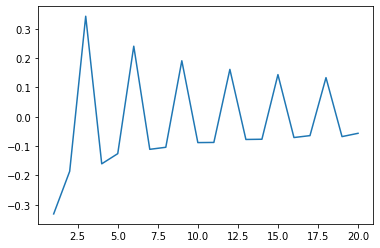

In [ ]:
plt.plot (range(1,21),corr1)

In [ ]:
#For Triangular EA lattice
x1 = []
x2 = []
corr2 = [] #Result of correlations between x1 and x2
x1.append (np.ravel(Tri_ea[:,0,24,:]))
x1.append (np.ravel(Tri_ea[:,24,0,:]))
x1 = np.concatenate (x1)

for _ in range (20):
    x2.append ([])
    corr2.append (0)

for r in range (20):
    x2[r].append (np.ravel(Tri_ea[:,0,r+25,:]))
    x2[r].append (np.ravel(Tri_ea[:,24,r+1,:]))
    x2[r] = np.concatenate (x2[r])
    corr2[r], _ = pearsonr (x1,x2[r])

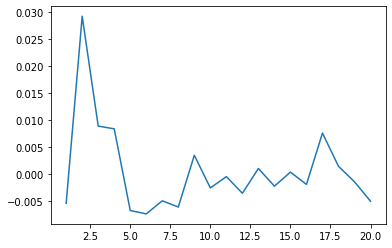

In [ ]:
plt.plot (range(1,21),corr2)

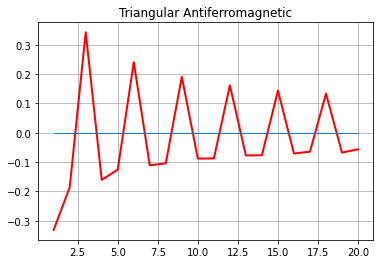

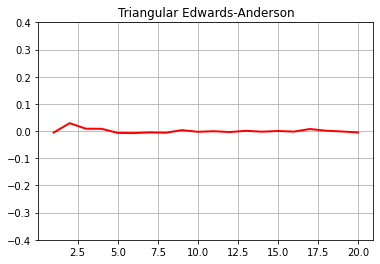

In [ ]:
_, ax1 = plt.subplots ()
ax1.set_title ('Triangular Antiferromagnetic')
ax1.plot (range(1,21),corr1,'r-',linewidth=2)
ax1.plot (range(1,21),np.zeros(20),linewidth=1)
ax1.grid()

_, ax2 = plt.subplots ()
ax2.set_title ('Triangular Edwards-Anderson')
ax2.set_ylim (-0.4,0.4)
ax2.plot (range(1,21),corr2,'r-',linewidth=2)
ax2.grid()
plt.show()

In [ ]:
Tri_ea_const = train_lattice

In [ ]:
#For Triangular EA lattice
x1 = []
x2 = []
corr3 = [] #Result of correlations between x1 and x2
x1.append (np.ravel(Tri_ea_const[:,0,24,:]))
x1.append (np.ravel(Tri_ea_const[:,24,0,:]))
x1 = np.concatenate (x1)

for _ in range (20):
    x2.append ([])
    corr3.append (0)

for r in range (20):
    x2[r].append (np.ravel(Tri_ea_const[:,0,r+25,:]))
    x2[r].append (np.ravel(Tri_ea_const[:,24,r+1,:]))
    x2[r] = np.concatenate (x2[r])
    corr3[r], _ = pearsonr (x1,x2[r])

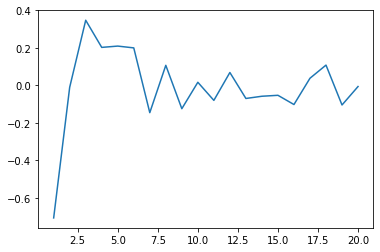

In [ ]:
plt.plot (range (1,21), corr3)

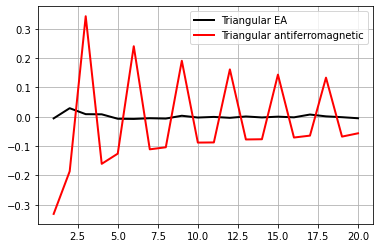

In [ ]:
_, ax1 = plt.subplots ()
ax1.plot (range(1,21),corr2,'black',linewidth=2,label='Triangular EA')
ax1.plot (range(1,21),corr1,'r-',linewidth=2,label='Triangular antiferromagnetic')
ax1.legend (loc='upper right')
ax1.grid()
plt.show()

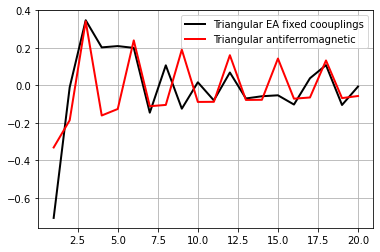

In [ ]:
_, ax2 = plt.subplots ()
ax2.plot (range(1,21),corr3,'black',linewidth=2,label='Triangular EA fixed coouplings')
ax2.plot (range(1,21),corr1,'r-',linewidth=2,label='Triangular antiferromagnetic')
ax2.legend (loc='upper right')
ax2.grid()
plt.show()